# Bài tập 2.1.4: Xây dựng cây quyết định và rừng cây trên dữ liệu bệnh tiểu đường

## 1. Xây dựng cây quyết định

### 1.1 Import thư viện

In [33]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### 1.2 Load dữ liệu

In [34]:
df = pd.read_csv('./data/diabetes_prediction_dataset.csv') #Load the cleaned data
features_response = df.columns.tolist() #Get a list of column names
#Make a list of columns to remove that aren't features or the response variable
# items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3',\
# 'PAY_4', 'PAY_5', 'PAY_6',\
# 'EDUCATION_CAT', 'graduate school',\
# 'high school', 'none',\
# 'others', 'university']
# features_response = [item for item in features_response if item not
# in items_to_remove]
# features_response

### 1.3 Chuẩn bị dữ liệu

In [35]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [37]:
df[df.duplicated()].shape

(3854, 9)

In [38]:
df = df.drop_duplicates()

In [52]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [39]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [40]:
df_encoder = df.copy()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'diabetes' in cat_cols:
    cat_cols.remove('diabetes')
cat_cols

['gender', 'smoking_history']

In [41]:
le = LabelEncoder()
for col in cat_cols:
    df_encoder[col] = le.fit_transform(df_encoder[col])
df_encoder.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0


### 1.4 Chia dữ liệu cho tập train và tập test

In [42]:
#Split the data into training and testing sets using the same random seed
X_train, X_test, y_train, y_test = train_test_split(df_encoder[features_response[:-1]].values,
df_encoder['diabetes'].values,
test_size=0.2, random_state=24)

### 1.5 Xây dựng cây quyết định 

In [43]:
# the tree will grow to a depth of at most 2
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 1.6 Hiển thị cây quyết định với package graphviz

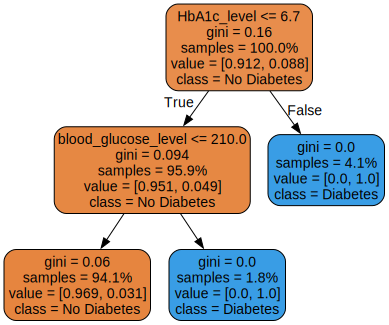

In [44]:
dot_data = tree.export_graphviz(
    dt,                                    # Decision Tree đã train
    out_file=None,                         # Không lưu file, trả về string
    filled=True,                           # Tô màu các node
    rounded=True,                          # Bo góc các node
    feature_names=features_response[:-1],  # Tên các features
    proportion=True,                       # Hiển thị tỉ lệ thay vì số lượng
    class_names=['No Diabetes', 'Diabetes']  # Tên các class
)

graph = graphviz.Source(dot_data)
graph

## 2. Tim tham số tối ưu cho cây quyết dịnh và vẽ biểu đồ đánh giá mô
hình

### 2.1 Tạo cây quyết định và xác định các giá trị tham số có thể chọn

- `scoring='roc_auc'`: GridSearchCV chọn mô hình có khả năng phân biệt giữa 2 lớp tốt nhất (theo xác suất dự đoán), thay vì chỉ xét độ chính xác (accuracy)
- `cv = 4`: dùng để kiểm định chéo (cross-validation), dữ liệu được chia thành 4 phần bằng nhau (3 phần train, 1 phần test) -> Giúp giảm thiên lệch (bias) do chia dữ liệu ngẫu nhiên, và đánh giá mô hình ổn định, khách quan hơn
- `return_train_score=True`: để đánh giá bias và variance, GridSearchCV sẽ lưu lại cả điểm đánh giá trên tập huấn luyện (train) bên cạnh điểm trên tập kiểm định (validation).


In [45]:

params = {'max_depth':[1, 2, 4, 6, 8, 10, 12]} #parameters
dt = tree.DecisionTreeClassifier() #tree modal
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc',
                    n_jobs=None, refit=True, cv=4, verbose=1,
                    error_score=np.nan,
                    return_train_score=True) # cv is the best model.
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'gini'


### 2.2 Vẽ biểu đồ đánh giá mô hình với các tham số chiều sâu của cây khác nhau

In [46]:
cv_results_df = pd.DataFrame(cv.cv_results_)
#View the names of the remaining columns in the results DataFrame
cv_results_df.columns


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
C:\Users\bim\AppData\Local\Temp\ipykernel_15876\4289456396.py:5: SyntaxWarning: invalid escape sequence '\p'
  label='Mean $\pm$ 1 SE training scores')
C:\Users\bim\AppData\Local\Temp\ipykernel_15876\4289456396.py:9: SyntaxWarning: invalid escape sequence '\p'
  label='Mean $\pm$ 1 SE testing scores')


Text(0, 0.5, 'ROC AUC')

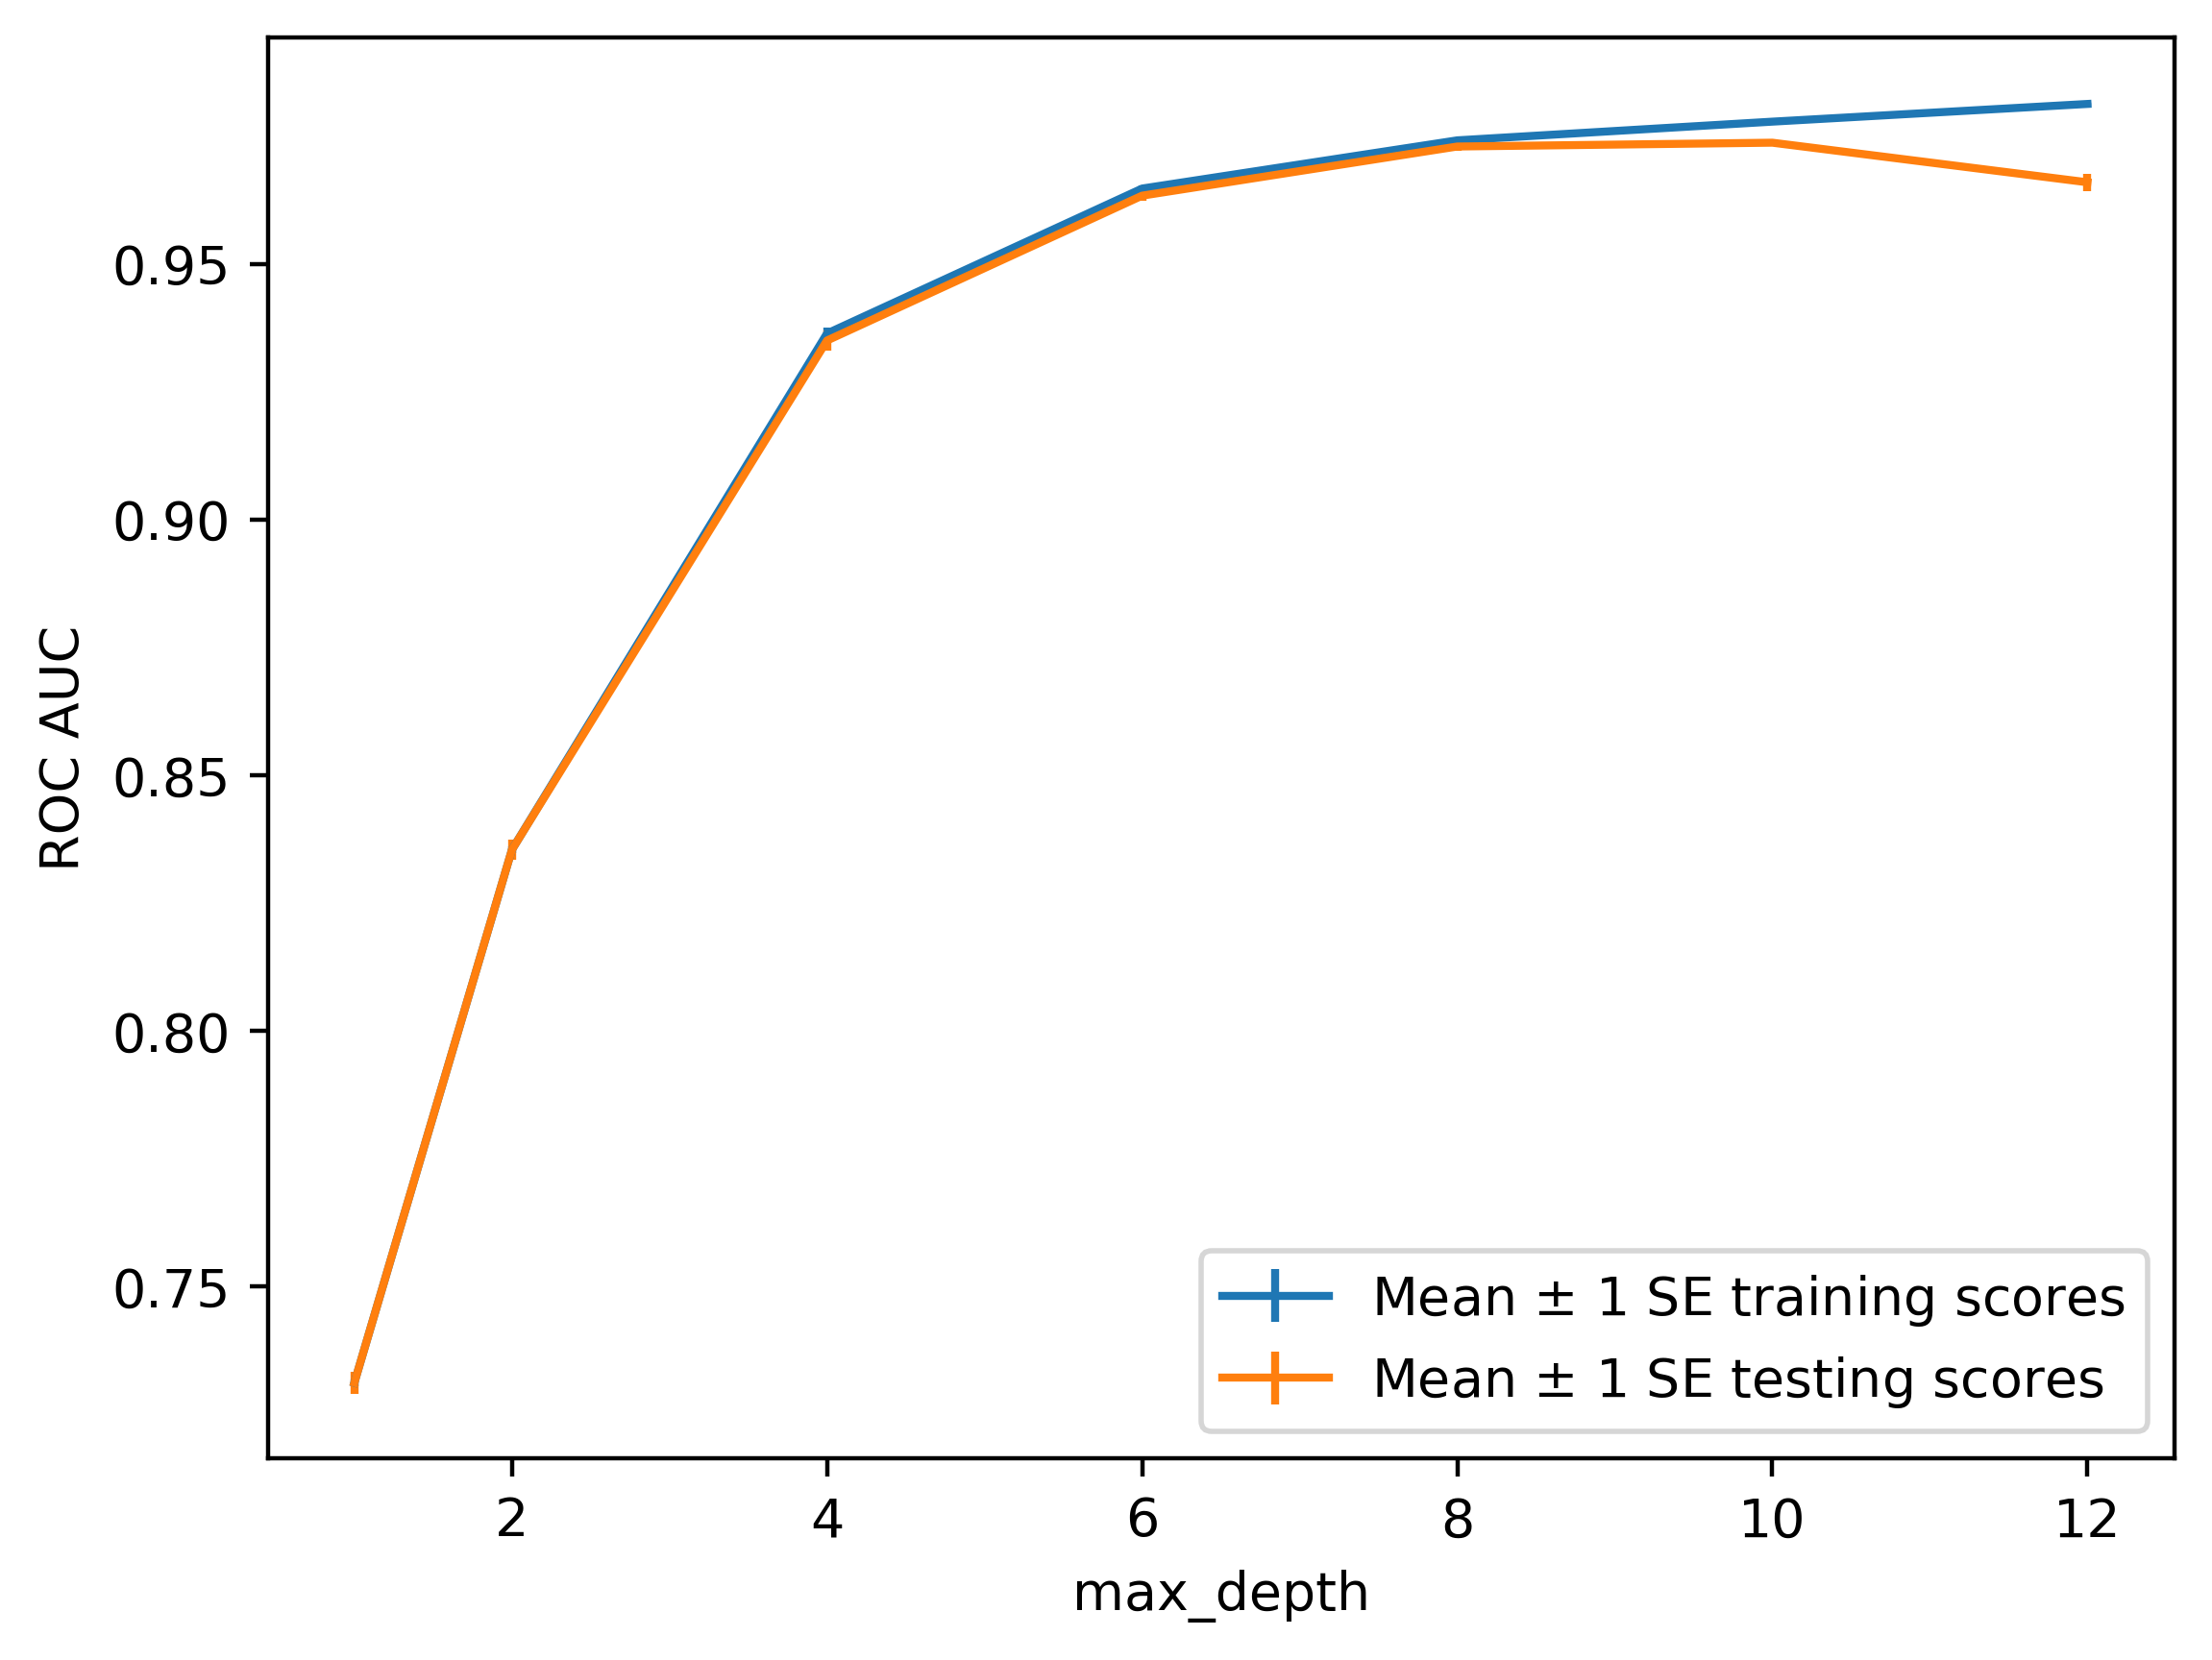

In [47]:
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
cv_results_df['mean_train_score'],
yerr=cv_results_df['std_train_score']/np.sqrt(4),
label='Mean $\pm$ 1 SE training scores')
ax.errorbar(cv_results_df['param_max_depth'],
cv_results_df['mean_test_score'],
yerr=cv_results_df['std_test_score']/np.sqrt(4),
label='Mean $\pm$ 1 SE testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

## 3. Xây dựng rừng cây (random forest)

### 3.2 Tạo rừng cây với lớp RandomForestClassifier

In [48]:
rf = RandomForestClassifier (n_estimators=10, criterion='gini', max_depth=3,
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            bootstrap=True, oob_score=False, n_jobs=None,
                            random_state=4, verbose=0, warm_start=False, class_weight=None)

### 3.3 Tìm tham số tối ưu cho mô hình rừng cây và thực hiện train với tham số tối ưu đó

In [49]:
#a parameter grid for this exercise in order to search the numbers of trees, ranging from 10 to 100 by 10s
rf_params_ex = {'n_estimators':list(range(10,110,10))}
cv_rf_ex = GridSearchCV(rf, param_grid=rf_params_ex,
scoring='roc_auc', n_jobs=None,
refit=True, cv=4, verbose=1,
error_score=np.nan,
return_train_score=True)

cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


,estimator,RandomForestC...andom_state=4)
,param_grid,"{'n_estimators': [10, 20, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,30


### 3.4 Vẽ biểu đồ đánh giá mô hình rừng cây với các tham số số cây có trong rừng khác nhau

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
C:\Users\bim\AppData\Local\Temp\ipykernel_15876\3136955479.py:12: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')


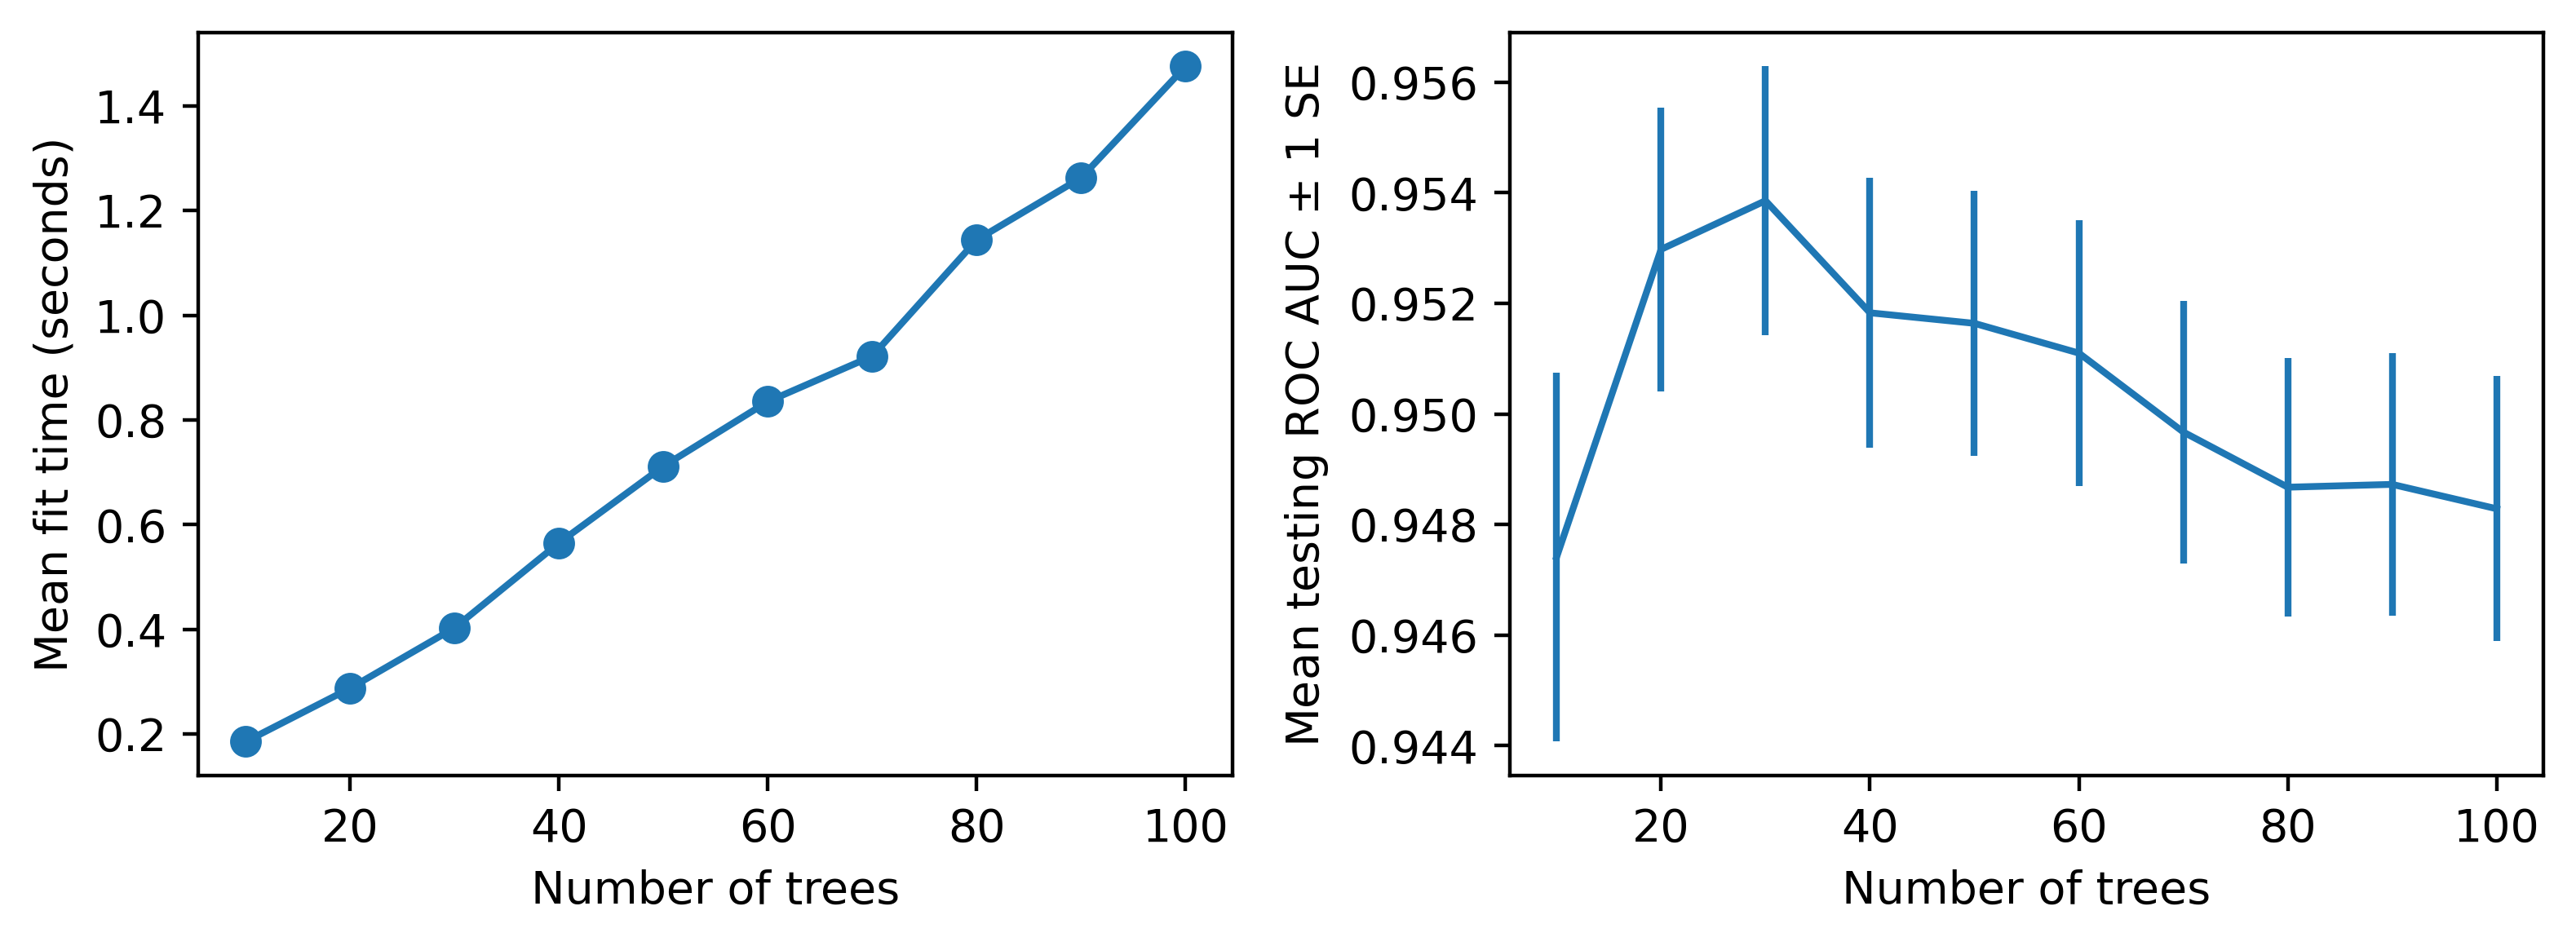

In [50]:
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
cv_rf_ex_results_df['mean_fit_time'],
'-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
cv_rf_ex_results_df['mean_test_score'],
yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')
plt.tight_layout()

### 3.5 Xem tham số tốt nhất và mức độ quan trọng của từng feature trong mô hình với tham số tốt nhất

<Axes: >

<Figure size 3200x1200 with 0 Axes>

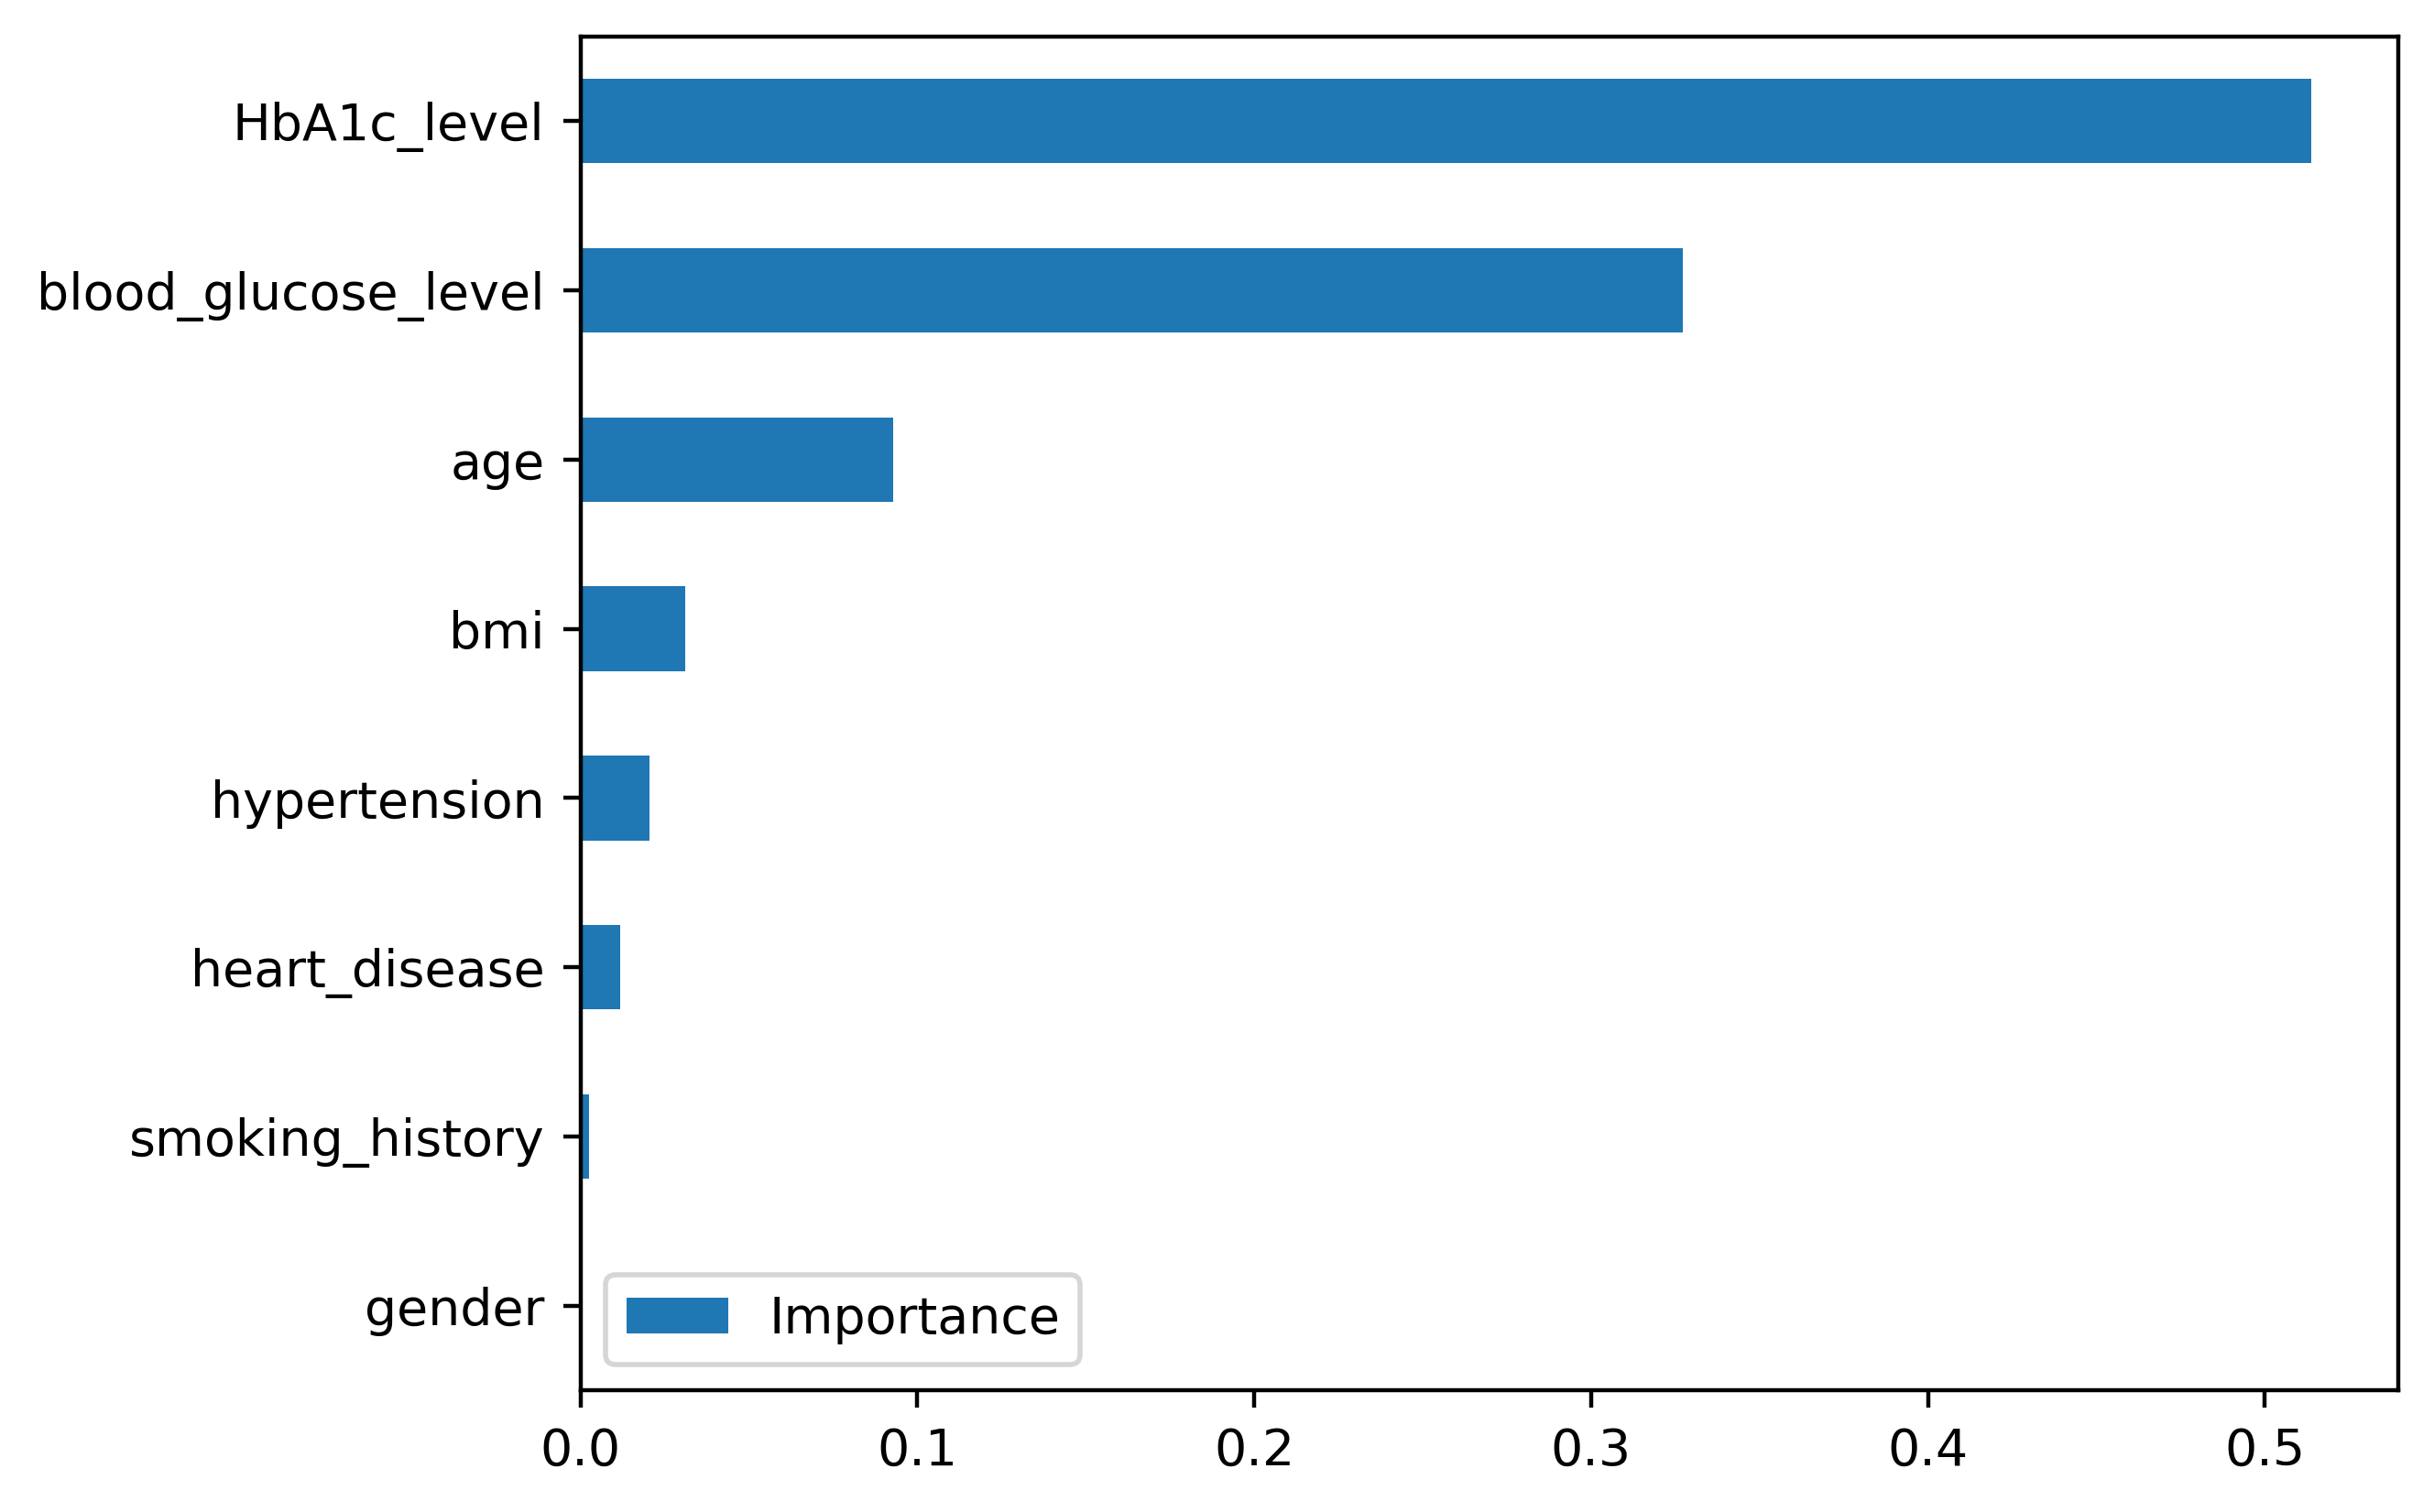

In [51]:
# {'n_estimators': 50}
cv_rf_ex.best_params_
# the feature names and importances
feat_imp_df = pd.DataFrame({'Importance':cv_rf_ex.best_estimator_.feature_importances_},
                            index=features_response[:-1])
plt.figure(figsize=(8,3))                    
feat_imp_df.sort_values('Importance', ascending=True).plot.barh()

# Kết thúc